# Lab 2 GNN

In [3]:
!pip install torch_geometric
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, global_mean_pool
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch


from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import torch.optim as optim
import torch.nn as nn
import torch

from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from scipy.io.arff import loadarff
from tqdm import tqdm
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.0 MB/s eta 0:00:00


In [14]:
#downloaded = drive.CreateFile({'id': train_id_ale})
#downloaded.GetContentFile('data_train.json')  # Download to a local file
train_df = pd.read_json('/kaggle/input/gnn-final/train.json')

#downloaded = drive.CreateFile({'id': test_id_ale})
#downloaded.GetContentFile('data_test.json')  # Download to a local file
test_df = pd.read_json('/kaggle/input/gnn-final/test.json')


In [3]:
train_df

,md5hash,api_call_sequence,is_malware
0,aaec2a99e23b2478ce5ec7f9b43c840c,"[NtClose, NtOpenKey, NtQueryValueKey, NtClose,...",1
1,14a9db02dd903a76adb275cf45d10413,"[GetSystemTimeAsFileTime, LdrLoadDll, LdrGetPr...",1
2,70f77a07109abab1983d98214f4eb199,"[RegOpenKeyExA, NtOpenKey, NtQueryValueKey, Nt...",1
3,fa67eebd3047eb2a4c9379623219d58d,"[RegOpenKeyExA, NtOpenKey, NtQueryValueKey, Nt...",1
4,d9209cdfe4fd24c6f2a17acdafa558a5,"[NtClose, NtOpenKey, NtQueryValueKey, NtClose,...",1
...,...,...,...
30708,fe46343b095fc1cb94a124f8b09899de,"[NtAllocateVirtualMemory, NtFreeVirtualMemory,...",1
30709,be5111ece71450ea095ea53a7b363b2c,"[GetSystemTimeAsFileTime, NtAllocateVirtualMem...",1
30710,4d237055a3d6de87dfce141ade1ffb55,"[NtClose, NtOpenKey, NtQueryValueKey, NtClose,...",1
30711,d755e305bace737948114d56bb3cb207,"[NtCreateFile, GetFileType, SetFilePointer, Nt...",1


In [15]:
# Dropping the md5 hash because since the sequences have been cut, they lose meaning
train_df = train_df.drop('md5hash',axis=1)
test_df = test_df.drop('md5hash',axis=1)
train_df

# 1. Remove empty api calls entries from dataset
train_df = train_df[train_df['api_call_sequence'].apply(len) > 0]
test_df = test_df[test_df['api_call_sequence'].apply(len) > 0]

train_df

,api_call_sequence,is_malware
0,"[NtClose, NtOpenKey, NtQueryValueKey, NtClose,...",1
1,"[GetSystemTimeAsFileTime, LdrLoadDll, LdrGetPr...",1
2,"[RegOpenKeyExA, NtOpenKey, NtQueryValueKey, Nt...",1
3,"[RegOpenKeyExA, NtOpenKey, NtQueryValueKey, Nt...",1
4,"[NtClose, NtOpenKey, NtQueryValueKey, NtClose,...",1
...,...,...
30708,"[NtAllocateVirtualMemory, NtFreeVirtualMemory,...",1
30709,"[GetSystemTimeAsFileTime, NtAllocateVirtualMem...",1
30710,"[NtClose, NtOpenKey, NtQueryValueKey, NtClose,...",1
30711,"[NtCreateFile, GetFileType, SetFilePointer, Nt...",1


In [16]:
#dropping duplicates, since the sequence have cut, there might be some sequence that deferred just for the last api calls
# Convert the 'api_call_sequence' column to tuples, which are hashable.
train_df['api_call_sequence'] = train_df['api_call_sequence'].apply(tuple)
test_df['api_call_sequence'] = test_df['api_call_sequence'].apply(tuple)
# Now you can drop duplicates
train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [17]:
train_df['api_call_sequence'] = train_df['api_call_sequence'].apply(list)
test_df['api_call_sequence'] = test_df['api_call_sequence'].apply(list)
train_df


,api_call_sequence,is_malware
0,"[NtClose, NtOpenKey, NtQueryValueKey, NtClose,...",1
1,"[GetSystemTimeAsFileTime, LdrLoadDll, LdrGetPr...",1
2,"[RegOpenKeyExA, NtOpenKey, NtQueryValueKey, Nt...",1
3,"[RegOpenKeyExA, NtOpenKey, NtQueryValueKey, Nt...",1
4,"[NtClose, NtOpenKey, NtQueryValueKey, NtClose,...",1
...,...,...
12871,"[SearchPathW, GetKeyState, FindResourceExW, Re...",1
12872,"[GetSystemTimeAsFileTime, LdrLoadDll, LdrGetPr...",1
12873,"[LdrLoadDll, LdrGetProcedureAddress, NtProtect...",1
12874,"[NtAllocateVirtualMemory, NtFreeVirtualMemory,...",1


In [18]:
# Function to encode a sequence (tokens not in the mapping get mapped to "<UNK>")
def encode_seq(seq, mapping):
    return [mapping.get(token, mapping["<UNK>"]) for token in seq]

from collections import Counter

# Extract all API calls from the training set
all_calls = [api for seq in train_df['api_call_sequence'] for api in seq]
call_counter = Counter(all_calls)
print("Top 10 most common API calls:")
print(call_counter.most_common(10))

# Build a vocabulary list and add a special <UNK> token for out-of-vocabulary API calls.
vocab = list(call_counter.keys())
vocab.append("<UNK>")
print("Vocabulary size:", len(vocab))

# Create a mapping: API call -> integer ID
api_to_int = {api: idx for idx, api in enumerate(vocab, start=1)}
int_to_api = {idx: api for api, idx in api_to_int.items()}



# Encode sequences in training and test sets
train_df['seq_encoded'] = train_df['api_call_sequence'].apply(lambda x: encode_seq(x, api_to_int))
test_df['seq_encoded']  = test_df['api_call_sequence'].apply(lambda x: encode_seq(x, api_to_int))


Top 10 most common API calls:
[('LdrGetProcedureAddress', 171129), ('LdrLoadDll', 93503), ('LdrGetDllHandle', 76170), ('NtClose', 57082), ('NtAllocateVirtualMemory', 49296), ('RegOpenKeyExW', 41934), ('RegCloseKey', 39584), ('RegQueryValueExW', 31898), ('NtQueryValueKey', 27019), ('NtOpenKey', 26703)]
Vocabulary size: 254


In [8]:
api_to_int

{'NtClose': 1,
 'NtOpenKey': 2,
 'NtQueryValueKey': 3,
 'LdrGetDllHandle': 4,
 'LdrGetProcedureAddress': 5,
 'GetSystemInfo': 6,
 'NtAllocateVirtualMemory': 7,
 'RegOpenKeyExW': 8,
 'FindFirstFileExW': 9,
 'LoadStringW': 10,
 'LdrLoadDll': 11,
 'GetNativeSystemInfo': 12,
 'GetTimeZoneInformation': 13,
 'RegQueryValueExW': 14,
 'RegCloseKey': 15,
 'SetErrorMode': 16,
 'GetSystemMetrics': 17,
 'FindResourceExW': 18,
 'OleInitialize': 19,
 'LoadResource': 20,
 'LookupAccountSidW': 21,
 'GetSystemTimeAsFileTime': 22,
 'SetUnhandledExceptionFilter': 23,
 'NtProtectVirtualMemory': 24,
 'NtCreateMutant': 25,
 'NtOpenKeyEx': 26,
 'NtQuerySystemInformation': 27,
 'GetSystemDirectoryW': 28,
 'NtEnumerateKey': 29,
 'NtEnumerateValueKey': 30,
 'GetSystemWindowsDirectoryW': 31,
 'CreateActCtxW': 32,
 'RegOpenKeyExA': 33,
 'NtQueryAttributesFile': 34,
 'LoadStringA': 35,
 'DrawTextExW': 36,
 'NtFreeVirtualMemory': 37,
 'RegQueryValueExA': 38,
 'LdrUnloadDll': 39,
 'NtCreateFile': 40,
 'GetFileType':

In [19]:
from torch_geometric.data import Data, Dataset

class GraphDataset(Dataset):
    def __init__(self, adj_matrices, features, labels, transform=None):
        """
        Initialize dataset by pre-processing all graphs into PyG `Data` format.

        Args:
            adj_matrices (list of np.array): List of adjacency matrices.
            features (list of np.array): List of node feature matrices.
            labels (list of int): List of graph labels.
            transform (callable, optional): Optional transform to apply to data.
        """
        super().__init__(transform)
        self.graphs = []  # Store processed graphs

        for i in range(len(adj_matrices)):
            # Convert adjacency matrix to edge index
            edge_index = torch.tensor(np.array(adj_matrices[i].nonzero()), dtype=torch.long)

            # Convert node features to the appropriate dtype based on the feature type
            if features[i].dtype == np.int64 or features[i].dtype == np.int32:
                 x = torch.tensor(features[i], dtype=torch.long)
            else:
                 x = torch.tensor(features[i], dtype=torch.float)

            # Ensure `y` is a single integer label
            #labels[i].nonzero()[0] to encode the label from a one-hot-encoding rappresentation
            #into a numerical version
            y = torch.tensor([labels[i]], dtype=torch.long)


            # Create Data object and store it
            self.graphs.append(Data(x=x, edge_index=edge_index, y=y))

    def len(self):
        return len(self.graphs)

    def get(self, idx):
        return self.graphs[idx]  # Return pre-processed graph

In [21]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

#Plot the graph using the networkx library
def plot_graph(data):
    """Visualize a PyTorch Geometric graph with node and edge features."""
    G = to_networkx(data, to_undirected=True)

    # Get node positions for consistent layout
    pos = nx.spring_layout(G, seed=42)

    # Draw the graph structure
    plt.figure(figsize=(7, 7))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray',
            node_size=800, font_size=7)

    # Format node features
    node_labels = {i: f"{[round(f, 2) for f in data.x[i].tolist()]}" for i in range(data.x.shape[0])}

    # Display node features slightly above nodes
    offset = 0.1  # Adjust for better visibility
    pos_shifted = {k: (v[0], v[1] + offset) for k, v in pos.items()}
    nx.draw_networkx_labels(G, pos_shifted, labels=node_labels, font_size=8, font_color="darkred")

    # Add edge features if available
    if hasattr(data, "edge_attr") and data.edge_attr is not None:
        edge_labels = {(u, v): f"{[round(e, 2) for e in data.edge_attr[idx].tolist()]}"
                       for idx, (u, v) in enumerate(data.edge_index.T.tolist())}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color="darkblue")

    plt.title(f"Graph Example - Label: {data.y.item()}")
    plt.show()

In [20]:
# now we need to create the ADJ_MATRIX AND THE FEATURE MATRIX
# We use Networkx to prepare the data to go from list -> to graph -> to adj matrix and feature matrix

import numpy as np

import torch
from scipy.sparse import lil_matrix
import networkx as nx
from scipy.sparse import lil_matrix

def create_adj_from_list(data_list):
    """
    Creates an adjacency matrix from a sequence of API call identifiers.
    Edges are defined by the sequence (i.e., [1,2,3] -> edges (1,2), (2,3)).

    Args:
        data_list: A list of integers or strings representing nodes.

    Returns:
        A SciPy sparse adjacency matrix (lil_matrix).
    """
    graph = nx.Graph()

    # Add sequential edges only if at least 2 nodes
    if len(data_list) > 1:
        edges = [(data_list[i], data_list[i + 1]) for i in range(len(data_list) - 1)]
        graph.add_edges_from(edges)

    graph.add_nodes_from(data_list)  # Ensure isolated nodes are added too

    if len(graph.nodes) == 0:
        return lil_matrix((1, 1))  # Return dummy matrix

    adj_matrix = nx.to_scipy_sparse_array(graph, format='lil')  # newer and preferred

    return adj_matrix



data_list = [1, 2, 3, 5, 2, 5]
print(create_adj_from_list(data_list))


# now i add the graph rappresentation in the dataset
train_df['adj_matrix'] = train_df['seq_encoded'].apply(lambda x: create_adj_from_list(x))
test_df['adj_matrix'] = test_df['seq_encoded'].apply(lambda x: create_adj_from_list(x))


train_df

<List of Lists sparse array of dtype 'int64'
	with 8 stored elements and shape (4, 4)>
  Coords	Values
  (0, 1)	1
  (1, 0)	1
  (1, 2)	1
  (1, 3)	1
  (2, 1)	1
  (2, 3)	1
  (3, 1)	1
  (3, 2)	1


,api_call_sequence,is_malware,seq_encoded,adj_matrix
0,"[NtClose, NtOpenKey, NtQueryValueKey, NtClose,...",1,"[1, 2, 3, 1, 2, 3, 1, 4, 5, 4, 5, 4, 5, 6, 7, ...",<List of Lists sparse array of dtype 'int64'\n...
1,"[GetSystemTimeAsFileTime, LdrLoadDll, LdrGetPr...",1,"[22, 11, 5, 11, 5, 4, 5, 4, 5, 23, 5, 24, 7, 1...",<List of Lists sparse array of dtype 'int64'\n...
2,"[RegOpenKeyExA, NtOpenKey, NtQueryValueKey, Nt...",1,"[33, 2, 3, 1, 2, 3, 1, 34, 35, 7, 35, 4, 5, 4,...",<List of Lists sparse array of dtype 'int64'\n...
3,"[RegOpenKeyExA, NtOpenKey, NtQueryValueKey, Nt...",1,"[33, 2, 3, 1, 2, 3, 1, 34, 35, 7, 35, 4, 5, 4,...",<List of Lists sparse array of dtype 'int64'\n...
4,"[NtClose, NtOpenKey, NtQueryValueKey, NtClose,...",1,"[1, 2, 3, 1, 2, 3, 1, 4, 5, 4, 5, 4, 5, 6, 7, ...",<List of Lists sparse array of dtype 'int64'\n...
...,...,...,...,...
12871,"[SearchPathW, GetKeyState, FindResourceExW, Re...",1,"[92, 165, 18, 8, 11, 5, 38, 7, 5, 11, 5, 7, 24...",<List of Lists sparse array of dtype 'int64'\n...
12872,"[GetSystemTimeAsFileTime, LdrLoadDll, LdrGetPr...",1,"[22, 11, 5, 11, 5, 11, 5, 11, 5, 4, 5, 4, 5, 2...",<List of Lists sparse array of dtype 'int64'\n...
12873,"[LdrLoadDll, LdrGetProcedureAddress, NtProtect...",1,"[11, 5, 24, 7, 16, 35, 19, 11, 5, 7, 37, 7, 6,...",<List of Lists sparse array of dtype 'int64'\n...
12874,"[NtAllocateVirtualMemory, NtFreeVirtualMemory,...",1,"[7, 37, 7, 41, 7, 24, 5, 24, 5, 24, 59, 7, 24,...",<List of Lists sparse array of dtype 'int64'\n...


In [22]:
import numpy as np
from typing import List, Dict

import numpy as np
import torch
from typing import List


def build_node_feature_matrix_id(adj_matrix: np.ndarray,
                                  seq_encoded: List[int],
                                  api_to_int: Dict[str, int] | Dict[int, int]) -> np.ndarray:
    """
    Create the node-feature matrix for a single graph with API IDs as features.
    
    Parameters
    ----------
    adj_matrix : (N, N) np.ndarray
        Dense adjacency matrix of *this* graph. It is used only to verify that
        the number of nodes (N) matches the feature rows we build.
    seq_encoded : list[int]
        Full sequence of API *global* ids in the order they were called,
        e.g. [1, 3, 22, 22, 5].
    api_to_int : dict
        Mapping of every possible API name (or id) to its global integer id.
        Used for validation purposes.
        
    Returns
    -------
    features : np.ndarray
        Dense feature matrix (N, 1) with API IDs as float32 values,
        ready for PyG / DGL.
    """
    # Unique node labels in order of first appearance
    node_api_ids = list(dict.fromkeys(seq_encoded))   # [1, 3, 22, 5] in the example
    
    # Sanity-check against the adjacency matrix
    num_nodes = adj_matrix.shape[0]
    if num_nodes != len(node_api_ids):
        raise ValueError(
            f"Adjacency is {num_nodes}×{num_nodes} but you supplied "
            f"{len(node_api_ids)} node ids."
        )
    
    # Validate API IDs are within expected range
    num_api_types = len(api_to_int)
    for api_id in node_api_ids:
        if not 1 <= api_id <= num_api_types:
            raise ValueError(f"API id {api_id} outside expected range 1…{num_api_types}")
    
    # Build the feature matrix: (N, 1) with API IDs as float32
    feats = np.asarray(node_api_ids, dtype=np.float32).reshape(-1, 1)
    
    return feats


# this one is for the one hot encoding
def build_node_feature_matrix(adj_matrix: np.ndarray,
                              seq_encoded: List[int],
                              api_to_int: Dict[str, int] | Dict[int, int],
                              one_hot: bool = True) -> np.ndarray:
    """
    Create the node-feature matrix for a single graph.

    Parameters
    ----------
    adj_matrix : (N, N) np.ndarray
        Dense adjacency matrix of *this* graph.  It is used only to verify that
        the number of nodes (N) matches the feature rows we build.
    seq_encoded : list[int]
        Full sequence of API *global* ids in the order they were called,
        e.g. [1, 3, 22, 22, 5].
    api_to_int : dict
        Mapping of every possible API name (or id) to its global integer id.
        Only its length is needed to size the one-hot matrix.
    one_hot : bool, default True
        • True  → return an (N, |API|) float32 one-hot matrix.
        • False → return an (N, 1)   int64  matrix of indices.

    Returns
    -------
    features : np.ndarray
        Dense feature matrix ready for PyG / DGL.
    """
    # Unique node labels in order of first appearance
    node_api_ids = list(dict.fromkeys(seq_encoded))   # [1, 3, 22, 5] in the example

    # Sanity-check against the adjacency matrix
    num_nodes = adj_matrix.shape[0]
    if num_nodes != len(node_api_ids):
        raise ValueError(
            f"Adjacency is {num_nodes}×{num_nodes} but you supplied "
            f"{len(node_api_ids)} node ids."
        )

    # Build the dense feature matrix
    if one_hot:
        num_api_types = len(api_to_int)
        feats = np.zeros((num_nodes, num_api_types), dtype=np.float32)

        # convert 1-based → 0-based for column index
        for row, api_id in enumerate(node_api_ids):
            col = api_id - 1
            if not 0 <= col < num_api_types:
                raise ValueError(f"API id {api_id} outside 1…{num_api_types}")
            feats[row, col] = 1.0
    else:
        feats = np.asarray(node_api_ids, dtype=np.int64).reshape(-1, 1)

    return feats


print(int_to_api.get(2))
print(int_to_api.get(1))

NtOpenKey
NtClose


In [18]:
import numpy as np
import pandas as pd

# Example row
example_row = {
    "api_call_sequence": ["NtClose", "NtOpenKey", "NtQueryValueKey"],
    "is_malware": 1,
    "seq_encoded": [1, 3, 22],  # API indices for each node
    "adj_matrix": np.array([
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0]
    ])
}

# API-to-index mapping, just for dimension (1..254)
# api_to_int = {f"api_{i+1}": i+1 for i in range(254)}  # dummy map

def create_feature_matrix_from_row(row, api_to_int):
    adj_matrix = row["adj_matrix"]
    seq_encoded = row["seq_encoded"]
    return build_node_feature_matrix(adj_matrix, seq_encoded, api_to_int)


# Apply it
feature_matrix = create_feature_matrix_from_row(example_row, api_to_int)
print(feature_matrix.shape)  # (3, 254)
print(feature_matrix)





(3, 254)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [26]:
example_row = {
    "api_call_sequence": ["NtClose", "NtOpenKey", "NtQueryValueKey"],
    "is_malware": 1,
    "seq_encoded": [1, 3, 22],          # 1-based ids
    "adj_matrix": np.array([
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0]
    ])
}

def create_feature_tensor_from_row(row):
    return build_node_feature_matrix_id(
        row["adj_matrix"],
        row["seq_encoded"],
        api_to_int)

feat = create_feature_tensor_from_row(example_row)
print(feat.shape)     # torch.Size([3, 1])
print(feat)

(3, 1)
[[ 1.]
 [ 3.]
 [22.]]


In [29]:
# Apply feature matrix creation to the full row, not just one column
#use create_feature_matrix_from_adj to use the one hot encoding instead
train_df['feature_matrix_OH'] = train_df.apply(lambda row: build_node_feature_matrix(
    row['adj_matrix'], row['seq_encoded'], api_to_int), axis=1)

test_df['feature_matrix_OH'] = test_df.apply(lambda row: build_node_feature_matrix(
    row['adj_matrix'], (row['seq_encoded']),api_to_int), axis=1)


train_df["feature_matrix_ID"] = train_df.apply(
    lambda row:  build_node_feature_matrix_id(
        row["adj_matrix"],
        row["seq_encoded"],
    api_to_int),
    axis=1
)

test_df["feature_matrix_ID"] = test_df.apply(
    lambda row:  build_node_feature_matrix_id(
        row["adj_matrix"],
        row["seq_encoded"],api_to_int
    ),
    axis=1
)

# Optional: drop rows where something failed and returned None
train_df = train_df[train_df['feature_matrix_OH'].notnull()]
test_df = test_df[test_df['feature_matrix_OH'].notnull()]
train_df = train_df[train_df['feature_matrix_ID'].notnull()]
test_df = test_df[test_df['feature_matrix_ID'].notnull()]


In [30]:
train_df

,api_call_sequence,is_malware,seq_encoded,adj_matrix,feature_matrix_OH,feature_matrix_ID
0,"[NtClose, NtOpenKey, NtQueryValueKey, NtClose,...",1,"[1, 2, 3, 1, 2, 3, 1, 4, 5, 4, 5, 4, 5, 6, 7, ...",<List of Lists sparse array of dtype 'int64'\n...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0], [2.0], [3.0], [4.0], [5.0], [6.0], [7...."
1,"[GetSystemTimeAsFileTime, LdrLoadDll, LdrGetPr...",1,"[22, 11, 5, 11, 5, 4, 5, 4, 5, 23, 5, 24, 7, 1...",<List of Lists sparse array of dtype 'int64'\n...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[22.0], [11.0], [5.0], [4.0], [23.0], [24.0],..."
2,"[RegOpenKeyExA, NtOpenKey, NtQueryValueKey, Nt...",1,"[33, 2, 3, 1, 2, 3, 1, 34, 35, 7, 35, 4, 5, 4,...",<List of Lists sparse array of dtype 'int64'\n...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[33.0], [2.0], [3.0], [1.0], [34.0], [35.0], ..."
3,"[RegOpenKeyExA, NtOpenKey, NtQueryValueKey, Nt...",1,"[33, 2, 3, 1, 2, 3, 1, 34, 35, 7, 35, 4, 5, 4,...",<List of Lists sparse array of dtype 'int64'\n...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[33.0], [2.0], [3.0], [1.0], [34.0], [35.0], ..."
4,"[NtClose, NtOpenKey, NtQueryValueKey, NtClose,...",1,"[1, 2, 3, 1, 2, 3, 1, 4, 5, 4, 5, 4, 5, 6, 7, ...",<List of Lists sparse array of dtype 'int64'\n...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0], [2.0], [3.0], [4.0], [5.0], [6.0], [7...."
...,...,...,...,...,...,...
12871,"[SearchPathW, GetKeyState, FindResourceExW, Re...",1,"[92, 165, 18, 8, 11, 5, 38, 7, 5, 11, 5, 7, 24...",<List of Lists sparse array of dtype 'int64'\n...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[92.0], [165.0], [18.0], [8.0], [11.0], [5.0]..."
12872,"[GetSystemTimeAsFileTime, LdrLoadDll, LdrGetPr...",1,"[22, 11, 5, 11, 5, 11, 5, 11, 5, 4, 5, 4, 5, 2...",<List of Lists sparse array of dtype 'int64'\n...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[22.0], [11.0], [5.0], [4.0], [23.0], [45.0],..."
12873,"[LdrLoadDll, LdrGetProcedureAddress, NtProtect...",1,"[11, 5, 24, 7, 16, 35, 19, 11, 5, 7, 37, 7, 6,...",<List of Lists sparse array of dtype 'int64'\n...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[11.0], [5.0], [24.0], [7.0], [16.0], [35.0],..."
12874,"[NtAllocateVirtualMemory, NtFreeVirtualMemory,...",1,"[7, 37, 7, 41, 7, 24, 5, 24, 5, 24, 59, 7, 24,...",<List of Lists sparse array of dtype 'int64'\n...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...","[[7.0], [37.0], [41.0], [24.0], [5.0], [59.0],..."


- Do you still have to pad your data? If yes, how?
  - No we don't have to BC -> teorical reasion
- Do you have to truncate the testing sequences? Justify your answer with your under
standing of why it is/it is not the case.
  - GNN work on graph and not with sequence, The number of nodes and edges can vary between graphs, and this doesn't break the model.
  - GNNs use message passing across graph structures; there’s no fixed-size input requirement.

# First we test the OH feature matrix

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    train_df, train_df['is_malware'],
    test_size=0.25, random_state=42, stratify=train_df['is_malware']
)

# Reset indices on all data
train_adj = X_train['adj_matrix'].reset_index(drop=True)
# Use feature_matrix_OH for GCN model without embedding
train_feat = X_train['feature_matrix_OH'].reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

val_adj = X_val['adj_matrix'].reset_index(drop=True)
# Use feature_matrix_OH for GCN model without embedding
val_feat = X_val['feature_matrix_OH'].reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

test_adj = test_df['adj_matrix'].reset_index(drop=True)
# Use feature_matrix_OH for GCN model without embedding
test_feat = test_df['feature_matrix_OH'].reset_index(drop=True)
y_test = test_df['is_malware'].reset_index(drop=True)

# Create datasets
train_dataset = GraphDataset(train_adj, train_feat, y_train)
val_dataset = GraphDataset(val_adj, val_feat, y_val)
test_dataset = GraphDataset(test_adj, test_feat, y_test)

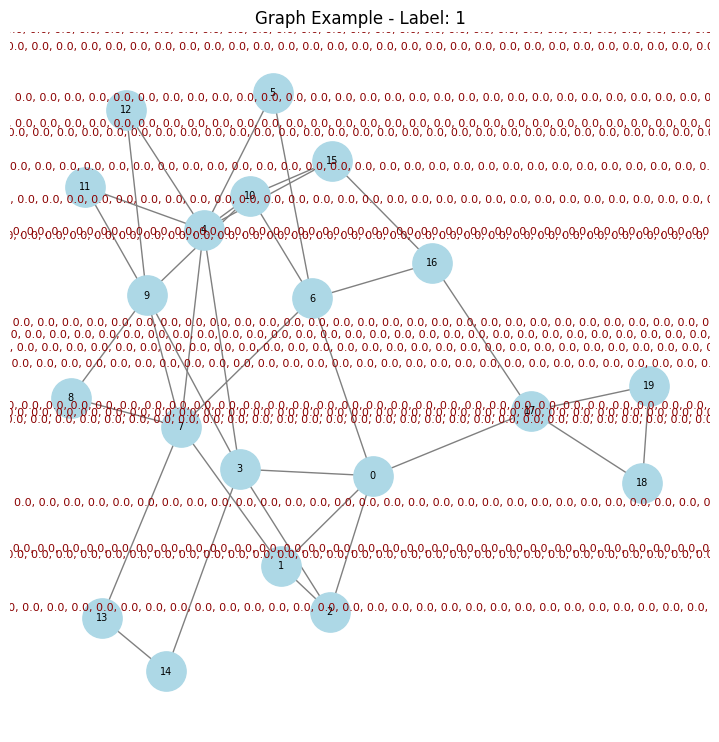

In [33]:
# print(train_dataset.print_summary())

plot_graph(test_dataset[2])

#Create DataLoaders

In [34]:
# Create DataLoader for batching
# NOTICE: This data loader is from torch_geometric.loader!! It is not from torch.utils.data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train loader: {len(train_loader)}, Validation loader: {len(val_loader)}, Test loader: {len(test_loader)}")

Train loader: 302, Validation loader: 101, Test loader: 230


In [35]:
batch = next(iter(train_loader))
batch
#x = [288, 5]: Node features: 288 total nodes, each with 5 features.
#edge_index = [2, 1810] Edges: A list of 1810 edges, stored as source-destination node pairs.
#y=[2, 1] = Graph labels: 19 graphs in the batch, each with a single class label.
#batch=[2712] = Graph indices: Maps each node to its respective graph in the batch.
#ptr=[3] = Graph separators: Pointer array marking where each graph starts in x and edge_index.

DataBatch(x=[689, 254], edge_index=[2, 2128], y=[32], batch=[689], ptr=[33])

# Defining the models
First we create a simple model then when we test also the other type we modify them in order to obtain better performance


In [36]:
#Simple GCN Model
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)  # Aggregate node features. From Node to Graph Features
        x = self.fc(x)
        return x



In [37]:
# Function to visualize model performance by creating a confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names, dataset_name, model_name):
    """
    Creates and displays a confusion matrix to evaluate classification performance.

    Args:
        y_true: Ground truth labels
        y_pred: Predicted labels
        class_names: List of class names for axis labels
    """
    cm = confusion_matrix(y_true, y_pred)  # Compute confusion matrix

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix +" +dataset_name+ " "+ model_name)
    plt.show()
    print("Classification Report:\n", classification_report(y_true, y_pred))

def training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, num_epochs, criterion):
    """
    Train the model for a specified number of epochs and track the training and validation losses.

    Args:
        model: The neural network model to be trained.
        train_loader: DataLoader for the training dataset.
        val_loader: DataLoader for the validation dataset.
        train_dataset: The entire training dataset.
        val_dataset: The entire validation dataset.
        device: Device to run the model on (CPU or GPU).
        optimizer: The optimization algorithm to use for updating model parameters.
        criterion: The loss function to use for computing the loss.

    Returns:
        None: The function plots the training and validation loss over the epochs.
    """


    # Record the start time
    start_time = time.time()


    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):  # Train for epochs
        train_loss = 0
        val_loss = 0
        model.train()  # Set model to training mode
        for batch in train_loader:
            batch = batch.to(device)  # Move batch to GPU

            batch.x = batch.x.type(torch.float).to(device)

            optimizer.zero_grad()  # Clear previous gradientss
            outputs = model(batch)  # Forward pass
            loss = criterion(outputs, batch.y.squeeze())  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters
            train_loss += loss.item() * batch.size(0)
        train_loss /= len(train_dataset)
        train_losses.append(train_loss)  # Store training loss

        # Compute Validation loss during training
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient computation for validation
            for batch in val_loader:
                batch = batch.to(device)  # Move batch to GPU
                val_outputs = model(batch)  # Forward pass
                loss = criterion(val_outputs, batch.y.squeeze())  # Compute validation loss. .squeeze() is used to reduce from 2D to 1D vector
                val_loss += loss.item() * batch.size(0)
            val_loss /= len(val_dataset)
            val_losses.append(val_loss)  # Store validation loss
            if (epoch + 1) % 20 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')


    # Record the end time
    end_time = time.time()
    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    print(f'The function took {elapsed_time:.4f} seconds to execute.')

    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    return

def testing_model(model, dataloader, device, dataset_name, model_name):
    """
    Evaluate the model on a given dataloader and compute accuracy.

    Args:
        model: The trained model.
        dataloader: DataLoader for the dataset.
        device: Device to run the model on (CPU or GPU).

    Returns:
        float: Accuracy of the model on the test dataset.
    """
    # Record the start time
    start_time = time.time()

    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # Disable gradient computation for efficiency
        for batch in dataloader:
            batch = batch.to(device)  # Move batch to GPU
            outputs = model(batch)
            _, predicted = torch.max(outputs, 1)  # Get the class with highest score
            all_labels.extend(batch.y.squeeze().cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions) * 100

    # Define class names
    class_names = [f"Class {cls}" for cls in np.unique(all_labels)]

    # Plot the confusion matrix
    plot_confusion_matrix(all_labels, all_predictions, class_names, dataset_name, model_name)

    # Record the end time
    end_time = time.time()
    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    print(f'The function took {elapsed_time:.4f} seconds to execute.')

    return accuracy

In [38]:
# this test was run before just using the index of the API call and is not meaniing full

for i, data in enumerate(train_dataset):
    if data.x.shape[0] == 0:
        print(f"Sample {i}: x has 0 rows")
# this check make sens only if we are using the OH shape
    if data.x.shape[1] != 254:
        print(f"Sample {i}: x has wrong number of features ({data.x.shape[1]})")

for i, data in enumerate(train_dataset):
  if hasattr(data, 'edge_index') and data.edge_index.numel() == 0:
      print(f"Sample {i}: edge_index is empty")

for i, data in enumerate(train_dataset):
    if not hasattr(data, 'y') or data.y.numel() == 0:
        print(f"Sample {i}: y is missing or empty")
    elif data.y.dim() > 1:
        print(f"Sample {i}: y has too many dimensions: {data.y.shape}")


## Simple GCN (with One Hot)
Start by creating a first simple GCN and train/test it first on the CPU and then on the
GPU. How long does it take to train and test in each configuration? How is it different
from previous architectures? Can you guess why?

Using cuda
Epoch 20/100, Train Loss: 1.7636, Val Loss: 2.1247
Epoch 40/100, Train Loss: 1.3904, Val Loss: 2.1079
Epoch 60/100, Train Loss: 1.0958, Val Loss: 2.2931
Epoch 80/100, Train Loss: 0.8559, Val Loss: 2.6504
Epoch 100/100, Train Loss: 0.7129, Val Loss: 2.8911
The function took 192.2386 seconds to execute.


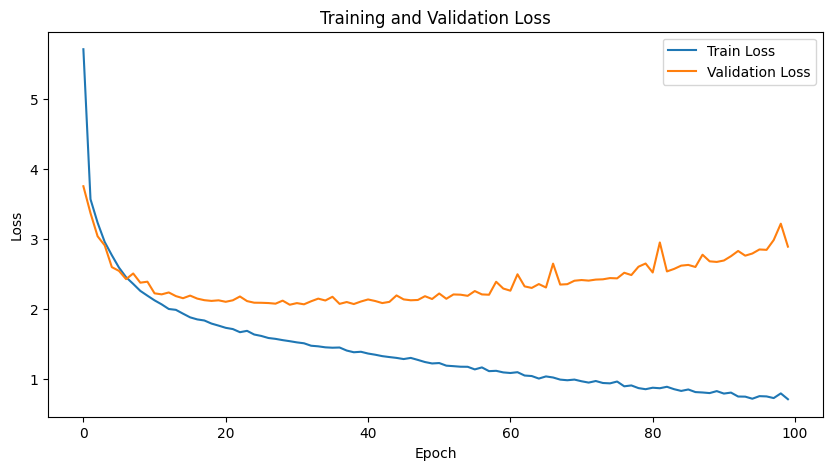

In [62]:
criterion = nn.CrossEntropyLoss()
num_epochs = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Using {device}')
# Update input_dim to be the size of the vocabulary
input_dim = train_feat.iloc[0].shape[1] # train_dataset.


# GCN
GCNmodel = GCN(input_dim=input_dim, hidden_dim=32, output_dim=2).to(device)
optimizer = optim.Adam(GCNmodel.parameters(), lr=0.001)
training_loop(GCNmodel, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, num_epochs, criterion)

GCNmodel


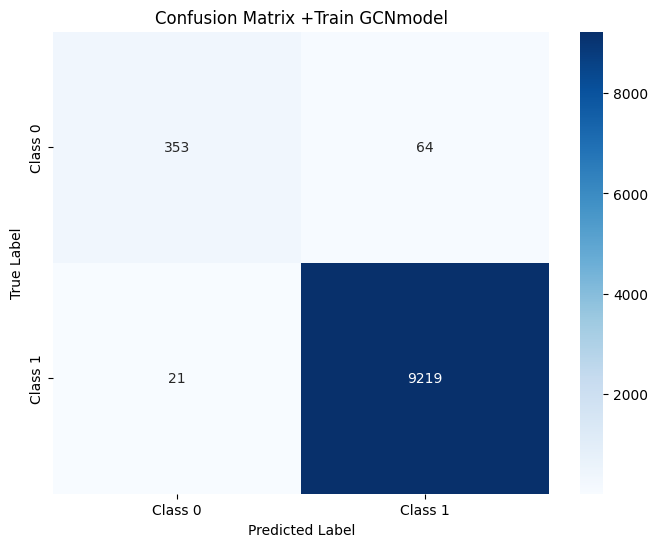

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.85      0.89       417
           1       0.99      1.00      1.00      9240

    accuracy                           0.99      9657
   macro avg       0.97      0.92      0.94      9657
weighted avg       0.99      0.99      0.99      9657

The function took 1.2409 seconds to execute.
Train Accuracy: 99.1198


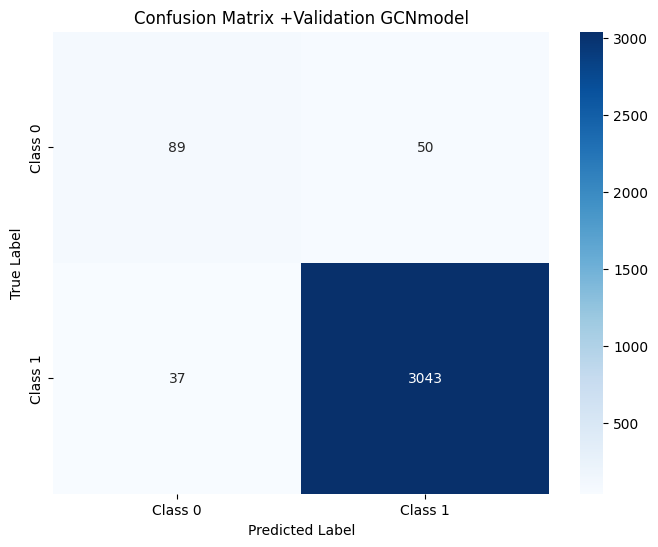

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.64      0.67       139
           1       0.98      0.99      0.99      3080

    accuracy                           0.97      3219
   macro avg       0.85      0.81      0.83      3219
weighted avg       0.97      0.97      0.97      3219

The function took 0.5154 seconds to execute.
Validation Accuracy: 97.2973


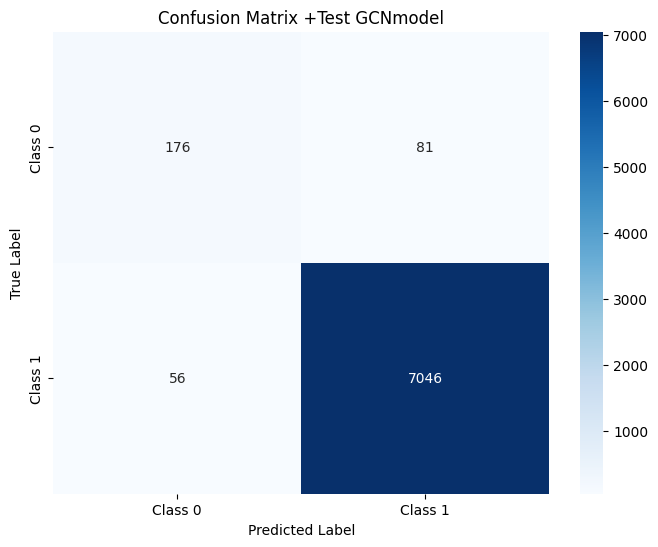

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.68      0.72       257
           1       0.99      0.99      0.99      7102

    accuracy                           0.98      7359
   macro avg       0.87      0.84      0.86      7359
weighted avg       0.98      0.98      0.98      7359

The function took 0.9866 seconds to execute.
Test Accuracy: 98.1383


In [26]:
model_names = ["GCNmodel"]
models = [GCNmodel]
for i in range(len(model_names)):
    model = models[i]
    print(model_names[i])
    train_accuracy = testing_model(model,train_loader,device,"Train",model_names[i])
    print(f'Train Accuracy: {train_accuracy:.4f}')
    val_accuracy = testing_model(model,val_loader,device,"Validation",model_names[i])
    print(f'Validation Accuracy: {val_accuracy:.4f}')
    test_accuracy = testing_model(model,test_loader,device,"Test",model_names[i])
    print(f'Test Accuracy: {test_accuracy:.4f}')

### Performance of the model w/o any dropout and weighted classes

Looking at the performance of the model from the learning curve we can see that the model has is clearly overfitting, so we need to either modify our data or modify our architecture
- add drop out layer
- use weighted class
- modify dataset
- tune hyper parameters
- reduce number of epochs

We decided to add drop out layer to the simple GNC to overcome overfit, we will see that the performance slightly improve
We also tried the weighted class (up)
The reason on why we wanted weighted class is to reduce FP, but in doing so we increased to much the false positive, which is not optimal for our goal.
We would like to have small FN and we may accept a high number of FP since it is better to suspect to have a malware even if the program is not actually harmfull, then to let a malware pass

(we tried models with 16 32 and 64 as hidden layer and we saw that the one with less overfitt was the one with 32 neurons as hidden layers)

## Model with weighted class + 32 hidden layer

Using cuda
Epoch 20/60, Train Loss: 5.7554, Val Loss: 6.3763
Epoch 40/60, Train Loss: 4.2761, Val Loss: 6.7263
Epoch 60/60, Train Loss: 3.7656, Val Loss: 8.5697
The function took 111.4011 seconds to execute.


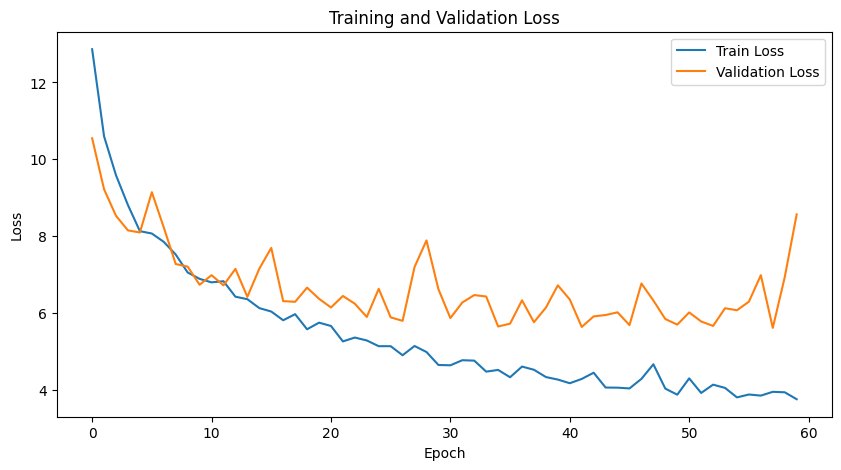

In [39]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume train_labels is a list or tensor of class indices (0, 1, 2)
train_labels = [label for data in train_dataset for label in [data.y.item()]]

# Compute weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Use weighted loss
criterion = nn.CrossEntropyLoss(weight=class_weights)
num_epochs = 60


print(f'Using {device}')
input_dim = train_feat.iloc[0].shape[1] 
dropout_rate = 0.1
weight_decay = 5e-4  # L2 regularization

# GCN
GCNmodel_weight = GCN(input_dim=input_dim, hidden_dim=32, output_dim=2).to(device)
optimizer = optim.Adam(GCNmodel_weight.parameters(), lr=0.005, weight_decay=weight_decay)
training_loop(GCNmodel_weight, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, num_epochs, criterion)




GCNmodel


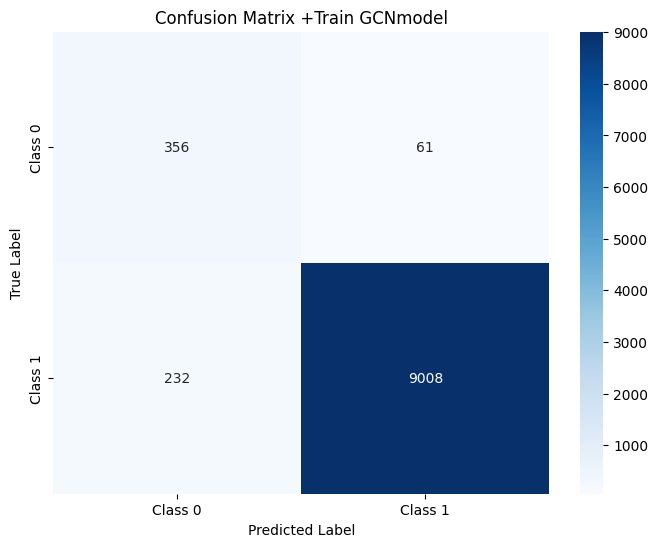

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.85      0.71       417
           1       0.99      0.97      0.98      9240

    accuracy                           0.97      9657
   macro avg       0.80      0.91      0.85      9657
weighted avg       0.98      0.97      0.97      9657

The function took 1.2648 seconds to execute.
Train Accuracy: 96.9659


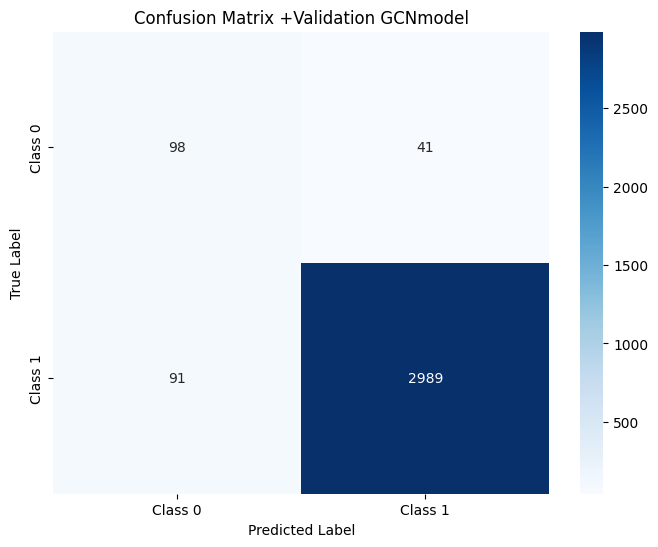

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.71      0.60       139
           1       0.99      0.97      0.98      3080

    accuracy                           0.96      3219
   macro avg       0.75      0.84      0.79      3219
weighted avg       0.97      0.96      0.96      3219

The function took 0.5163 seconds to execute.
Validation Accuracy: 95.8993


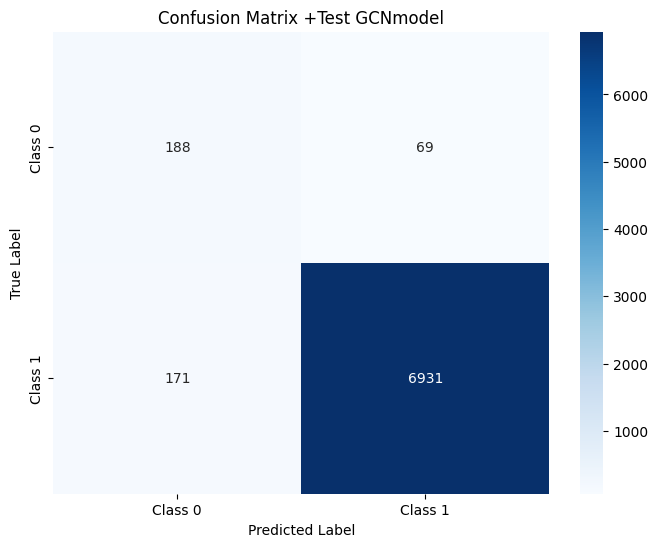

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.73      0.61       257
           1       0.99      0.98      0.98      7102

    accuracy                           0.97      7359
   macro avg       0.76      0.85      0.80      7359
weighted avg       0.97      0.97      0.97      7359

The function took 0.9596 seconds to execute.
Test Accuracy: 96.7387


In [40]:
model_names = ["GCNmodel_weight"]
models = [GCNmodel_weight]
for i in range(len(model_names)):
    model = models[i]
    print(model_names[i])
    train_accuracy = testing_model(model,train_loader,device,"Train",model_names[i])
    print(f'Train Accuracy: {train_accuracy:.4f}')
    val_accuracy = testing_model(model,val_loader,device,"Validation",model_names[i])
    print(f'Validation Accuracy: {val_accuracy:.4f}')
    test_accuracy = testing_model(model,test_loader,device,"Test",model_names[i])
    print(f'Test Accuracy: {test_accuracy:.4f}')

We reduced the numbers of false negatives (101 before) on the test set but also increased the number of FP (that previously was 66)

## Model with drop out layer

In [50]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, global_mean_pool

# GCN
class GCN_dropout(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(GCN_dropout, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.dropout = dropout
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x




Using cuda
Epoch 20/100, Train Loss: 1.9044, Val Loss: 2.0613
Epoch 40/100, Train Loss: 1.6140, Val Loss: 2.0181
Epoch 60/100, Train Loss: 1.4338, Val Loss: 2.0393
Epoch 80/100, Train Loss: 1.2547, Val Loss: 2.1206
Epoch 100/100, Train Loss: 1.0763, Val Loss: 2.3046
The function took 188.7445 seconds to execute.


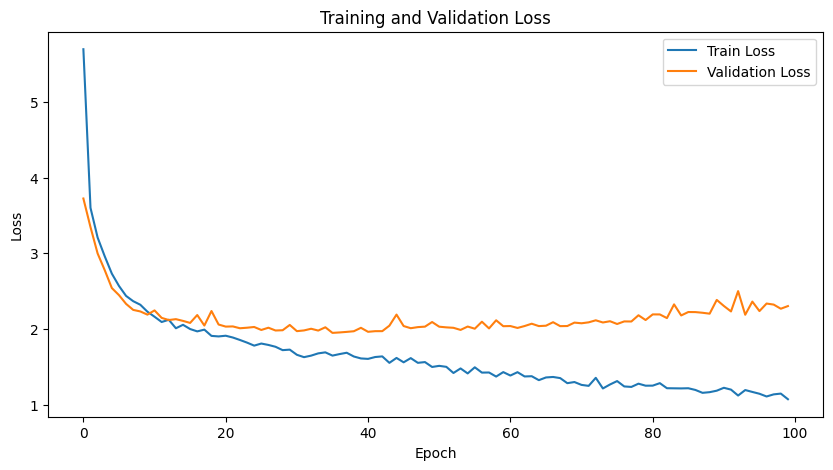

In [51]:
print(f'Using {device}')
input_dim = train_feat.iloc[0].shape[1]
#print(input_dim)
dropout_rate = 0.1

# Use weighted loss
criterion = nn.CrossEntropyLoss()
num_epochs = 100


GCNmodel_dropout = GCN_dropout(input_dim=input_dim, hidden_dim=32, output_dim=2).to(device)
optimizer = optim.Adam(GCNmodel_dropout.parameters(), lr=0.001)
training_loop(GCNmodel_dropout, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, num_epochs, criterion)

GCNmodel_dropout


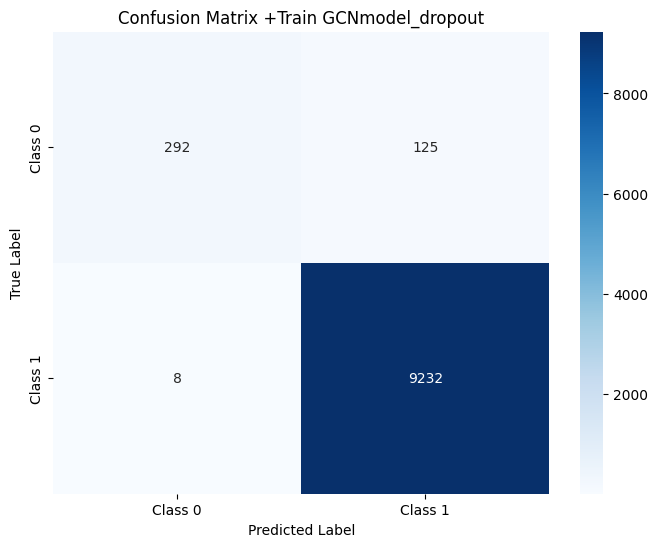

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.70      0.81       417
           1       0.99      1.00      0.99      9240

    accuracy                           0.99      9657
   macro avg       0.98      0.85      0.90      9657
weighted avg       0.99      0.99      0.99      9657

The function took 1.3157 seconds to execute.
Train Accuracy: 98.6228


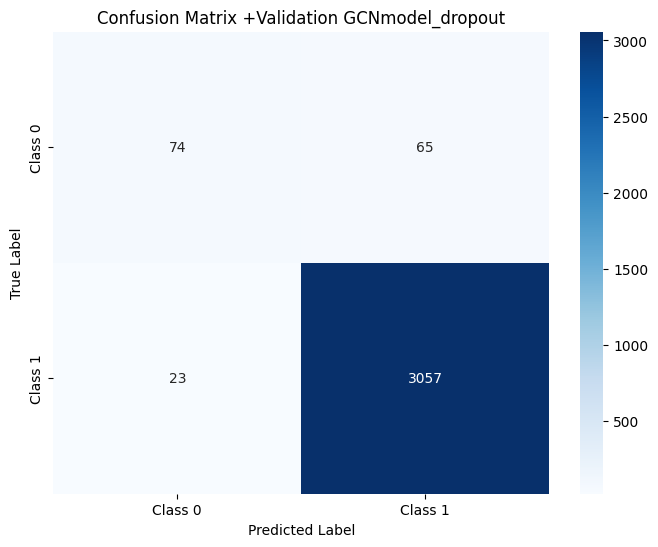

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.53      0.63       139
           1       0.98      0.99      0.99      3080

    accuracy                           0.97      3219
   macro avg       0.87      0.76      0.81      3219
weighted avg       0.97      0.97      0.97      3219

The function took 0.5263 seconds to execute.
Validation Accuracy: 97.2662


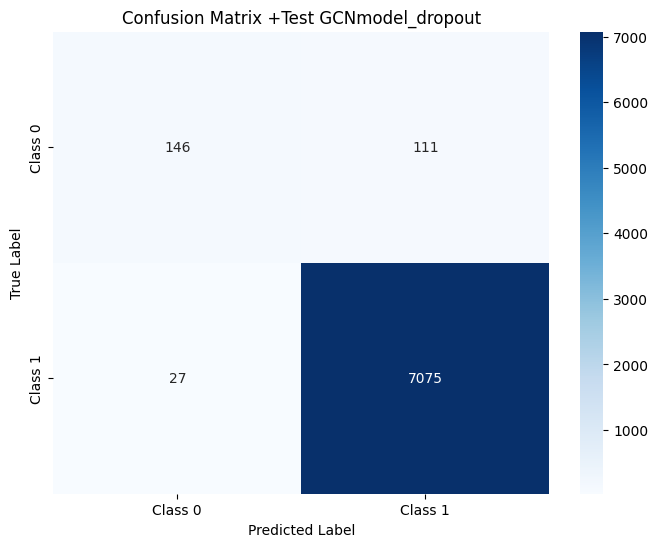

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.57      0.68       257
           1       0.98      1.00      0.99      7102

    accuracy                           0.98      7359
   macro avg       0.91      0.78      0.83      7359
weighted avg       0.98      0.98      0.98      7359

The function took 0.9945 seconds to execute.
Test Accuracy: 98.1247


In [52]:
#Test the models
model_names = ["GCNmodel_dropout"]
models = [GCNmodel_dropout]
for i in range(len(model_names)):
    model = models[i]
    print(model_names[i])
    train_accuracy = testing_model(model,train_loader,device,"Train",model_names[i])
    print(f'Train Accuracy: {train_accuracy:.4f}')
    val_accuracy = testing_model(model,val_loader,device,"Validation",model_names[i])
    print(f'Validation Accuracy: {val_accuracy:.4f}')
    test_accuracy = testing_model(model,test_loader,device,"Test",model_names[i])
    print(f'Test Accuracy: {test_accuracy:.4f}')

- This seems to be one of the best model if just look at the FN rates and precision, we see that the model still has a high number of FP but overall the general performance are not terrible and we have some improvement in respect with the other, although we can still see thorugh the validation courve that the modell may overfit 

Using simple ID we get that the model mostly puts everytihng into the malware category, and also the training phase is unstable and characterized with a lot of spikes, meaning that the model is not converging touwards a good solution, let's see what happens when we add drop out layers or change other parameters


This model has really poor performance, the model is totally underfitting and it is not able to be used 
So we decided to Use the model that kept the one hot encoding



One thing to notice is that if we want to use the model with the IDs we need to have a highere size in the hidden layer in order to see some results, having just the IDs as feature might not be enough for the GNN to trach patterns unless we have more neurons
The poor performance that we get using the IDs might also be caused by how we created the feature matrix, but we are not complitely sure 

# Comparison of different architectures


In [39]:
#GCN Model
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)  # Aggregate node features. From Node to Graph Features
        x = self.fc(x)
        return x

#GraphSAGE Model
class GraphSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)# Aggregate node features. From Node to Graph Features
        x = self.fc(x)
        return x

#GAT Model (Graph Attention Network)
class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=8):
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads, concat=True)
        self.conv2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, concat=False)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch) # Aggregate node features. From Node to Graph Features
        x = self.fc(x)
        return x


# Model with one hot encode

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    train_df, train_df['is_malware'],
    test_size=0.25, random_state=42, stratify=train_df['is_malware']
)

# Reset indices on all data
train_adj = X_train['adj_matrix'].reset_index(drop=True)
# Use feature_matrix_OH for GCN model without embedding
train_feat = X_train['feature_matrix_OH'].reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

val_adj = X_val['adj_matrix'].reset_index(drop=True)
# Use feature_matrix_OH for GCN model without embedding
val_feat = X_val['feature_matrix_OH'].reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

test_adj = test_df['adj_matrix'].reset_index(drop=True)
# Use feature_matrix_OH for GCN model without embedding
test_feat = test_df['feature_matrix_OH'].reset_index(drop=True)
y_test = test_df['is_malware'].reset_index(drop=True)

# Create datasets
train_dataset = GraphDataset(train_adj, train_feat, y_train)
val_dataset = GraphDataset(val_adj, val_feat, y_val)
test_dataset = GraphDataset(test_adj, test_feat, y_test)
# Create DataLoader for batching
# NOTICE: This data loader is from torch_geometric.loader!! It is not from torch.utils.data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train loader: {len(train_loader)}, Validation loader: {len(val_loader)}, Test loader: {len(test_loader)}")

Train loader: 302, Validation loader: 101, Test loader: 230


Using cuda
Epoch 20/100, Train Loss: 2.5698, Val Loss: 2.5749
Epoch 40/100, Train Loss: 2.3118, Val Loss: 2.3441
Epoch 60/100, Train Loss: 2.1512, Val Loss: 2.2012
Epoch 80/100, Train Loss: 2.0521, Val Loss: 2.1365
Epoch 100/100, Train Loss: 1.9352, Val Loss: 2.0878
The function took 233.8352 seconds to execute.


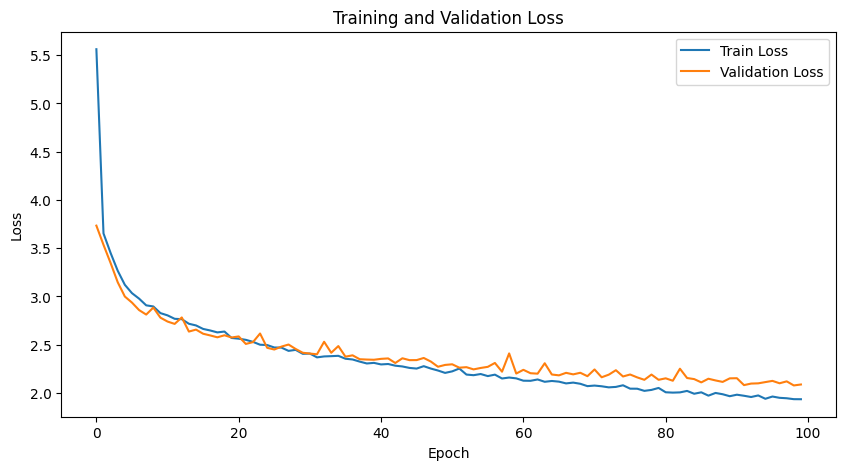

Epoch 20/100, Train Loss: 2.1269, Val Loss: 2.1809
Epoch 40/100, Train Loss: 1.6884, Val Loss: 1.9517
Epoch 60/100, Train Loss: 1.4953, Val Loss: 1.8298
Epoch 80/100, Train Loss: 1.3602, Val Loss: 1.8796
Epoch 100/100, Train Loss: 1.2973, Val Loss: 1.7915
The function took 203.5484 seconds to execute.


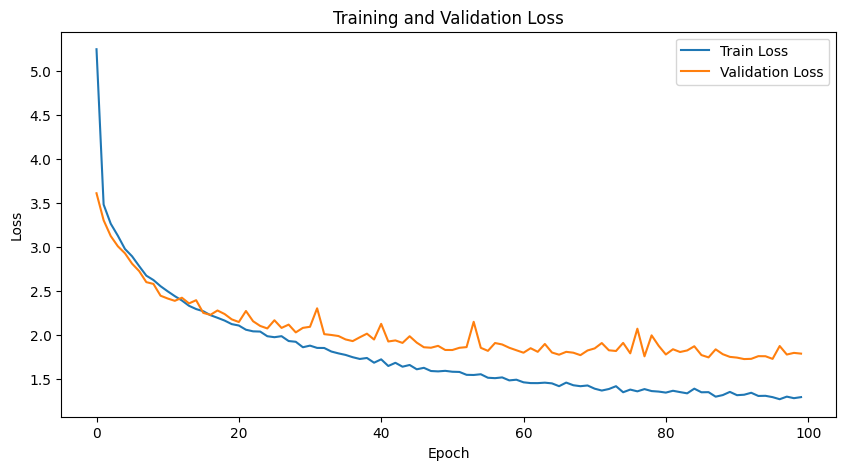

Epoch 20/100, Train Loss: 2.4311, Val Loss: 2.7447
Epoch 40/100, Train Loss: 2.2694, Val Loss: 2.3328
Epoch 60/100, Train Loss: 2.1757, Val Loss: 2.3165
Epoch 80/100, Train Loss: 2.0766, Val Loss: 2.1905
Epoch 100/100, Train Loss: 1.9858, Val Loss: 2.1962
The function took 298.1675 seconds to execute.


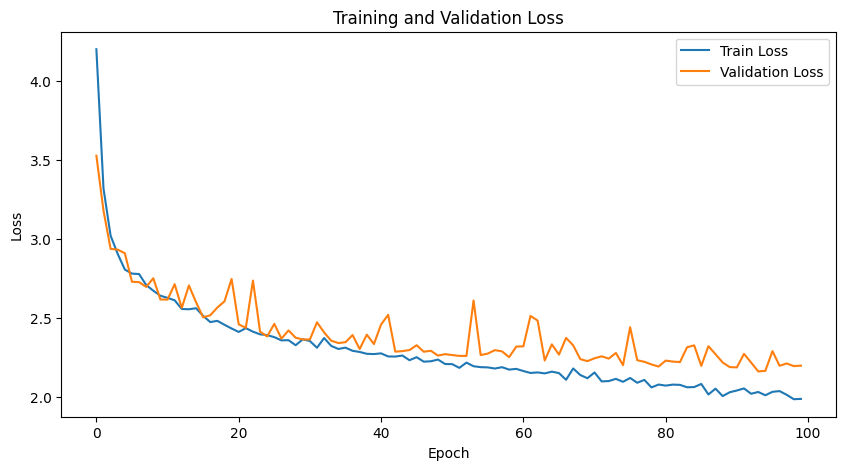

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume train_labels is a list or tensor of class indices (0, 1, 2)
train_labels = [label for data in train_dataset for label in [data.y.item()]]

# Compute weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Use weighted loss
criterion = nn.CrossEntropyLoss()

print(f'Using {device}')
input_dim = train_feat.iloc[0].shape[1]
dropout_rate = 0.1
weight_decay = 5e-4  # L2 regularization
num_epochs = 100

# GCN
GCNmodel_OH = GCN(input_dim=input_dim, hidden_dim=32, output_dim=2).to(device)
optimizer = optim.Adam(GCNmodel_OH.parameters(), lr=0.001, weight_decay=weight_decay)
training_loop(GCNmodel_OH, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, num_epochs, criterion)

# GraphSAGE
GraphSAGEmodel_OH = GraphSAGE(input_dim=input_dim, hidden_dim=32, output_dim=2).to(device)
optimizer = optim.Adam(GraphSAGEmodel_OH.parameters(), lr=0.001, weight_decay=weight_decay)
training_loop(GraphSAGEmodel_OH, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, num_epochs, criterion)

# GAT
GATmodel_OH = GAT(input_dim=input_dim, hidden_dim=32, output_dim=2).to(device)
optimizer = optim.Adam(GATmodel_OH.parameters(), lr=0.001, weight_decay=weight_decay)
training_loop(GATmodel_OH, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, num_epochs, criterion)

GCNmodel


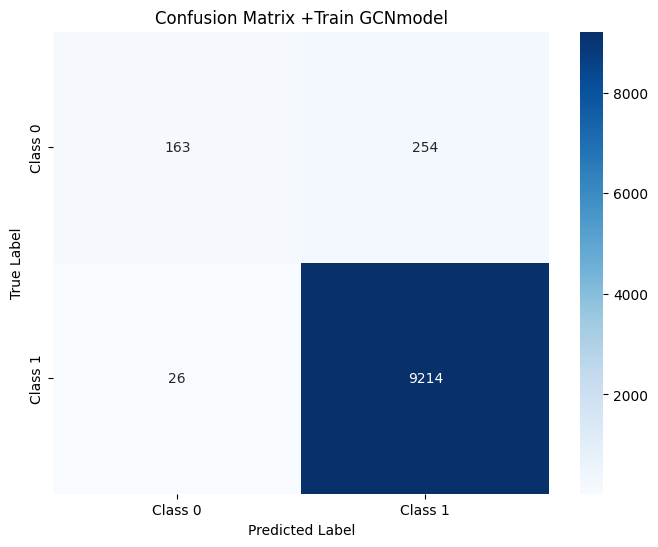

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.39      0.54       417
           1       0.97      1.00      0.99      9240

    accuracy                           0.97      9657
   macro avg       0.92      0.69      0.76      9657
weighted avg       0.97      0.97      0.97      9657

The function took 1.4980 seconds to execute.
Train Accuracy: 97.1005


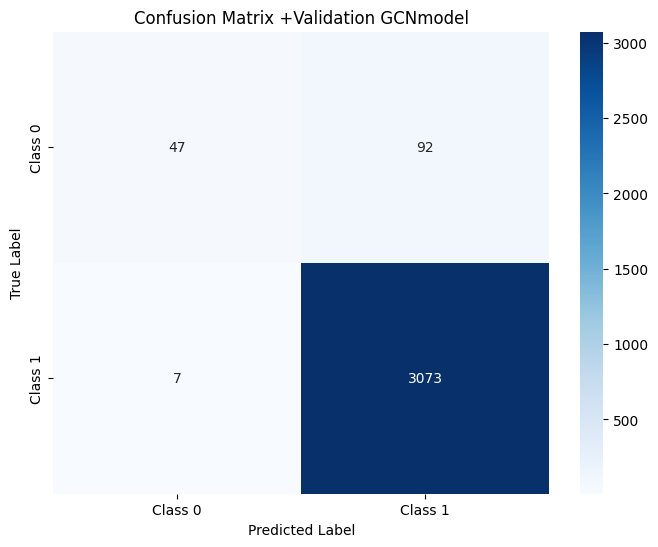

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.34      0.49       139
           1       0.97      1.00      0.98      3080

    accuracy                           0.97      3219
   macro avg       0.92      0.67      0.74      3219
weighted avg       0.97      0.97      0.96      3219

The function took 0.6397 seconds to execute.
Validation Accuracy: 96.9245


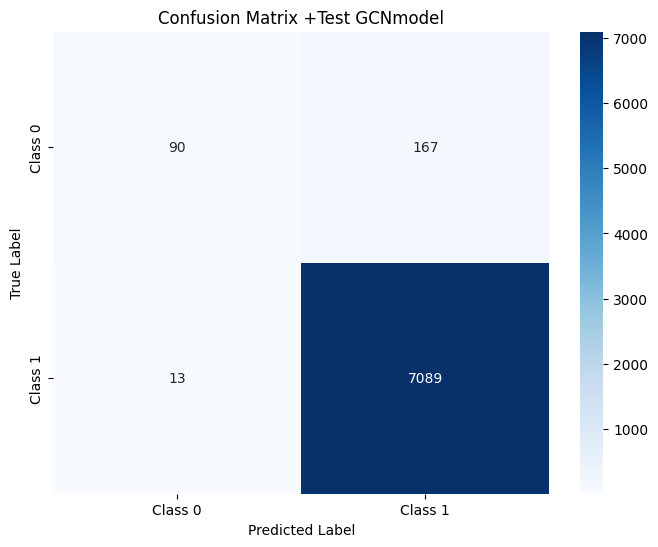

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.35      0.50       257
           1       0.98      1.00      0.99      7102

    accuracy                           0.98      7359
   macro avg       0.93      0.67      0.74      7359
weighted avg       0.97      0.98      0.97      7359

The function took 1.1664 seconds to execute.
Test Accuracy: 97.5540
GraphSAGEmodel


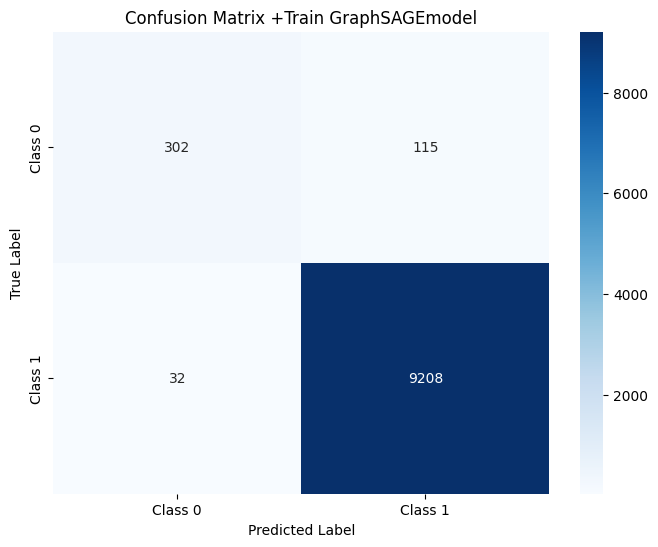

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.72      0.80       417
           1       0.99      1.00      0.99      9240

    accuracy                           0.98      9657
   macro avg       0.95      0.86      0.90      9657
weighted avg       0.98      0.98      0.98      9657

The function took 1.3223 seconds to execute.
Train Accuracy: 98.4778


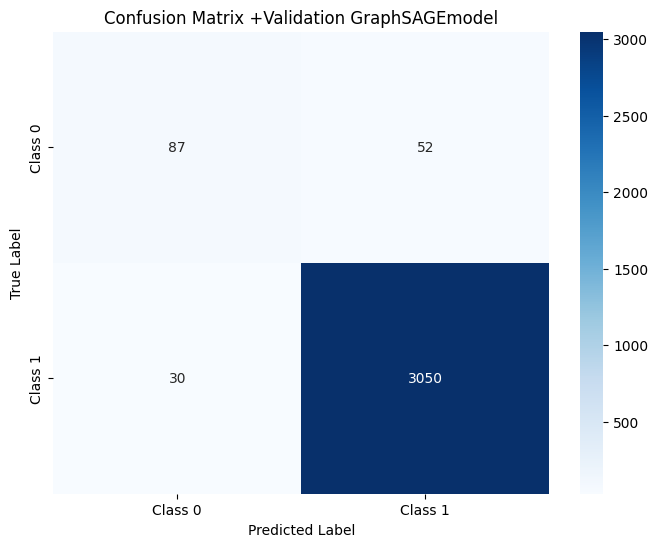

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.63      0.68       139
           1       0.98      0.99      0.99      3080

    accuracy                           0.97      3219
   macro avg       0.86      0.81      0.83      3219
weighted avg       0.97      0.97      0.97      3219

The function took 0.5843 seconds to execute.
Validation Accuracy: 97.4526


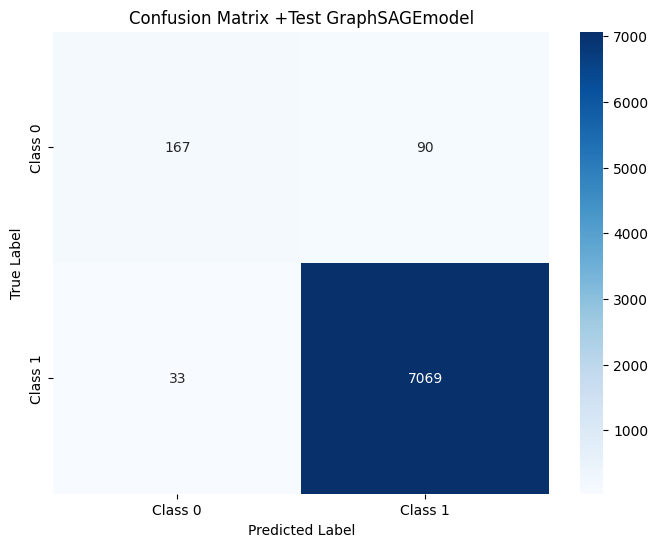

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.65      0.73       257
           1       0.99      1.00      0.99      7102

    accuracy                           0.98      7359
   macro avg       0.91      0.82      0.86      7359
weighted avg       0.98      0.98      0.98      7359

The function took 1.0919 seconds to execute.
Test Accuracy: 98.3286
GATmodel


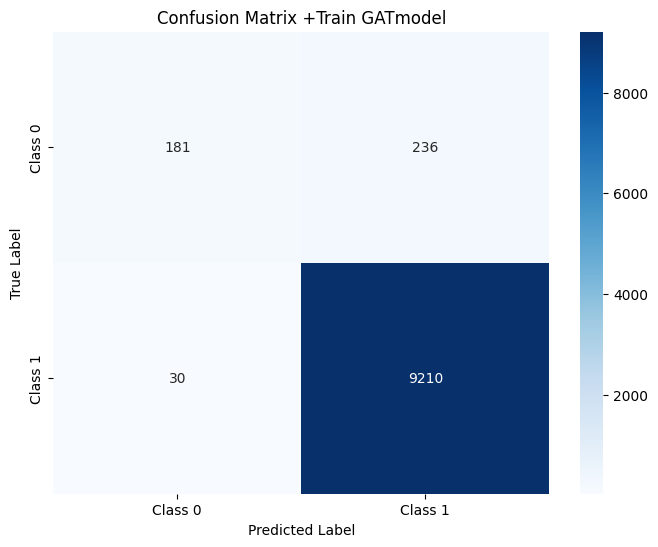

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.43      0.58       417
           1       0.98      1.00      0.99      9240

    accuracy                           0.97      9657
   macro avg       0.92      0.72      0.78      9657
weighted avg       0.97      0.97      0.97      9657

The function took 1.8121 seconds to execute.
Train Accuracy: 97.2455


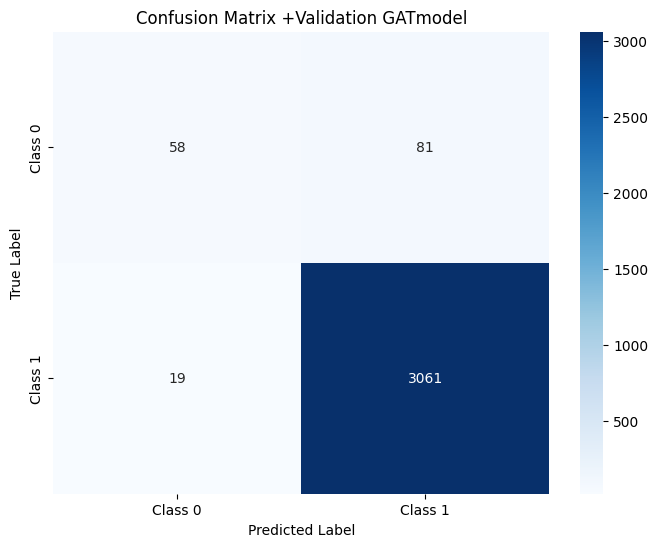

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.42      0.54       139
           1       0.97      0.99      0.98      3080

    accuracy                           0.97      3219
   macro avg       0.86      0.71      0.76      3219
weighted avg       0.96      0.97      0.96      3219

The function took 0.7806 seconds to execute.
Validation Accuracy: 96.8934


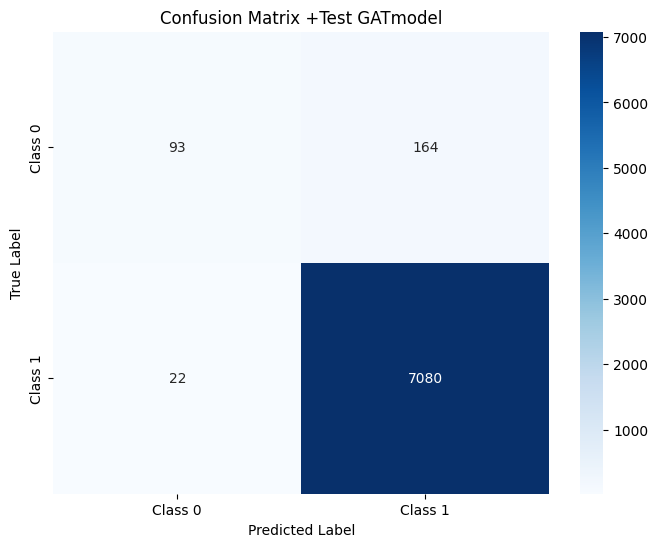

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.36      0.50       257
           1       0.98      1.00      0.99      7102

    accuracy                           0.97      7359
   macro avg       0.89      0.68      0.74      7359
weighted avg       0.97      0.97      0.97      7359

The function took 2.2181 seconds to execute.
Test Accuracy: 97.4725


In [44]:
#Test the models
model_names = ["GCNmodel","GraphSAGEmodel","GATmodel"]
models = [GCNmodel_OH,GraphSAGEmodel_OH,GATmodel_OH]
for i in range(len(model_names)):
    model = models[i]
    print(model_names[i])
    train_accuracy = testing_model(model,train_loader,device,"Train",model_names[i])
    print(f'Train Accuracy: {train_accuracy:.4f}')
    val_accuracy = testing_model(model,val_loader,device,"Validation",model_names[i])
    print(f'Validation Accuracy: {val_accuracy:.4f}')
    test_accuracy = testing_model(model,test_loader,device,"Test",model_names[i])
    print(f'Test Accuracy: {test_accuracy:.4f}')